## Importing packages

In [1]:
import time
import copy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# From torch
import torch
## nn
import torch.nn as nn
import torch.nn.functional as F
## optim
import torch.optim as optim
from torch.optim import lr_scheduler
## utils
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
## torchvision
import torchvision
from torchvision import datasets, models, transforms

## Loading and transormation

The data used as an example is an image data stored as a single csv file with each row representing an image. Each image is 48*48 pixel stored as a vector of length 2304. The initial column is the emotion represented to each column. The types of emotions are present. Happy, Sad and fear.

#### General

Creating category to label encodoing and the inverted mapping

In [3]:
cls2id = {"Happy": 0, "Sad": 1, "Fear": 2}
id2cls = ["Happy", "Sad", "Fear"]

Defining data length, batch size, path of the dataset and the device to use for computation. CPU or GPU

In [4]:
BATCHSIZE = 10
PATH = "data/FER2013_csv.csv"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Custom function

Custom function from scratch to process the data is devided into four functions.

1. load_data()    : To load the data and normalize it and also doing the other required steps to create the image.
2. loader()       : Loader calls load_data to load data and then tranform the data to tensor and make encofing of the labels.
3. data_split()   : To split the dataset into rain and test.
4. create_batch() : To create random batch with mentioned size. It returns a file which upon calling works same as dataloader

In [26]:
def load_data(PATH):
    data     = pd.read_csv(PATH)
    labels   = data["emotion"]
    data     = data.drop(["emotion"], axis = 1)
    images   = np.array(data.values).reshape(len(data.values), 48, 48)
    images   = images/255
    return images, labels
    
def loader(PATH):
    images, labels = load_data(PATH)
    images = torch.tensor(images)
    images = images.view(images.shape[0], -1, images.shape[1], images.shape[2])

    target = []
    for label in labels.values:
        target.append(cls2id[label])
    target = torch.tensor(target)
    
    return images, target

def data_split(X, Y, test_size, shuffle = True):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, shuffle = shuffle)
    return(X_train, X_test, Y_train, Y_test)

def create_batch(X, Y, batch_size = 1):
    batch_x = [X[i: i + batch_size] for i in range(0, len(X), batch_size)]
    batch_y = [Y[i: i + batch_size] for i in range(0, len(Y), batch_size)] 
    return list(zip(batch_x, batch_y))

In [27]:
images, target = loader(PATH)
train_X, test_X, train_Y, test_Y = data_split(images, target, test_size = 0.3) 
trainloader = create_batch(train_X, train_Y, batch_size = BATCHSIZE)
testloader = create_batch(test_X, test_Y, batch_size = BATCHSIZE)

## ResNet 101 Model 1

In [340]:
class RESNET(nn.Module):
    def __init__(self, base_model = None criterion = None, optimizer = None, learning_rate = 0.001, image_dimention = 1, categories = 3):
        super(RESNET, self).__init__()
        ## Defining networt
         # Defaulf input image dimention is 1
         # Default output categories is 3
        self.pretrained = models.resnet152(pretrained = True)
        self.pretrained.conv1 = nn.Conv2d(image_dimention, 64, kernel_size = (3, 3), stride=(2,2), padding=(3,3), bias=False)
        num_ftrs = self.pretrained.fc.in_features
        self.pretrained.fc = nn.Linear(num_ftrs, categories)
        
        ## Defining optimizer and loss function
         # Default loss function is cross entropy
         # Default optimizer is SGD
         # Default learning rate is 0.001
        if criterion is not None:
            self.criterion = criterion
        else:
            self.criterion = nn.CrossEntropyLoss()
        if optimizer  is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = optim.SGD(self.pretrained.parameters(), lr = learning_rate, momentum = 0.9)
        
    def forward(self, x):
        x = self.pretrained.forward(x)
        return x
        
    def train(self, traindata, valdata = None, numberEpoch = 10):
        
        trainlen = sum(list(batch[0].shape[0] for batch in traindata))
        total_batch = len(traindata)
        ## Loop over the dataset multiple times
        for epoch in range(numberEpoch): 
            running_corrects = 0.0
            running_loss     = 0.0
            pbar = tqdm(enumerate(traindata, 0), total = total_batch, desc = "Loss 0, Completed", ncols = 800)
            for count, data in pbar:
                inputs, labels = data[0].to(device), data[1].to(device)
                batch  = inputs.shape[0]
                inputs = inputs.type(torch.cuda.FloatTensor)
                
                ## zero the parameter gradients
                self.optimizer.zero_grad()
                
                ## forward + backward + optimize
                outputs = self.forward(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                ## Calculating statistics
                running_loss += loss.item() * batch
                running_corrects += torch.sum(preds == labels.data)
                
                ## Showing statistics
                pbar.set_description("Loss %.3f, Completed" %(running_loss/trainlen))
            epoch_loss = running_loss/trainlen
            epoch_acc  = running_corrects/trainlen
            print('Epoch %d completed, average loss: %.3f, accuracy: %.3f' %(epoch + 1, epoch_loss, epoch_acc))
            
            if valdata:
                val_loss, val_acc = self.evaluate(valdata)
                print('Validation, average loss: %.3f, accuracy: %.3f' %(val_loss, val_acc))
                
    def evaluate(self, testdata):
        running_corrects = 0.0
        running_loss     = 0.0
        testlen = sum(list(batch[0].shape[0] for batch in testdata))
        for data in testdata:
            inputs, labels = data[0].to(device), data[1].to(device)
            batch  = inputs.shape[0]
            inputs = inputs.type(torch.cuda.FloatTensor)            
            ## Forward
            outputs = self.forward(inputs)
            _, preds = torch.max(outputs, 1)
            ## Loss and accuracy
            loss = criterion(outputs, labels)
            running_loss += loss.item() * batch
            running_corrects += torch.sum(preds == labels.data)
            
        loss = running_loss/testlen
        acc  = running_corrects/testlen
        return loss, acc
        
    def predict(self, testdata, ID = None):
        predicted_labels = []
        for data in testdata:
            inputs, labels = data[0].to(device), data[1].to(device)
            batch  = inputs.shape[0]
            inputs = inputs.type(torch.cuda.FloatTensor)            
            ## Forward
            outputs = self.forward(inputs)
            _, preds = torch.max(outputs, 1)
            predicted_labels += preds.tolist()
        if ID:
            return([ID[label] for label in predicted_labels])
        return predicted_labels
    
def freeze_grad(model, percent_to_freeze = .80):
    maxlayers = len(list(model.pretrained.children()))
    freeze = int(maxlayers * percent_to_freeze)
    print("Number of layers:: ", maxlayers)
    print("Layers Freezed  :: ", freeze)
    count = 0
    for child in model.pretrained.children():
        if count >= freeze:
            break
        for param in child.parameters():
            param.requires_grad = False
        count += 1

In [328]:
model = RESNET()
freeze_grad(model, 0.0)
model = model.to(device)

Number of layers::  10
Layers Freezed  ::  0


In [341]:
# model.train(trainloader, valdata = testloader, numberEpoch = 30)

In [310]:
prediction = model.predict(testloader)
print("Accuracy:: ", accuracy_score(test_Y.tolist(), prediction))

0.5104744300677757

## VGG Net 

In [39]:
class VGGNET(nn.Module):
    def __init__(self, criterion = None, optimizer = None, learning_rate = 0.001, image_dimention = 1, categories = 3):
        super(VGGNET, self).__init__()
        ## Defining networt
         # Defaulf input image dimention is 1
         # Default output categories is 3
        self.pretrained = models.vgg19(pretrained = True)
        self.pretrained.features[0] = nn.Conv2d(image_dimention, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        num_ftrs = self.pretrained.classifier[6].in_features
        self.pretrained.classifier[6] = nn.Linear(num_ftrs, categories)
        
        ## Defining optimizer and loss function
         # Default loss function is cross entropy
         # Default optimizer is SGD
         # Default learning rate is 0.001
        if criterion:
            self.criterion = criterion
        else:
            self.criterion = nn.CrossEntropyLoss()
#             self.criterion = nn.NLLLoss()
        if optimizer:
            self.optimizer = optimizer
        else:
#             self.optimizer = optim.SGD(self.pretrained.parameters(), lr = learning_rate, momentum = 0.9)
            self.optimizer = optim.Adam(self.pretrained.parameters(), lr = learning_rate)
        
    def forward(self, x):
        x = self.pretrained.forward(x)
        return x
        
    def train(self, traindata, valdata = None, numberEpoch = 10):
        
        trainlen = sum(list(batch[0].shape[0] for batch in traindata))
        total_batch = len(traindata)
        ## Loop over the dataset multiple times
        for epoch in range(numberEpoch): 
            running_corrects = 0.0
            running_loss     = 0.0
            pbar = tqdm(enumerate(traindata, 0), total = total_batch, desc = "Loss 0, Completed", ncols = 800)
            for count, data in pbar:
                inputs, labels = data[0].to(device), data[1].to(device)
                batch  = inputs.shape[0]
                inputs = inputs.type(torch.cuda.FloatTensor)
                
                ## zero the parameter gradients
                self.optimizer.zero_grad()
                
                ## forward + backward + optimize
                outputs = self.forward(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                ## Calculating statistics
                running_loss += loss.item() * batch
                running_corrects += torch.sum(preds == labels.data)
                
                ## Showing statistics
                pbar.set_description("Loss %.3f, Completed" %(running_loss/trainlen))
            epoch_loss = running_loss/trainlen
            epoch_acc  = running_corrects/trainlen
            print('Epoch %d completed, average loss: %.3f, accuracy: %.3f' %(epoch + 1, epoch_loss, epoch_acc))
            
            if valdata:
                val_loss, val_acc = self.evaluate(valdata)
                print('Validation, average loss: %.3f, accuracy: %.3f' %(val_loss, val_acc))
                
    def evaluate(self, testdata):
        running_corrects = 0.0
        running_loss     = 0.0
        testlen = sum(list(batch[0].shape[0] for batch in testdata))
        with torch.no_grad():
            for data in testdata:
                inputs, labels = data[0].to(device), data[1].to(device)
                batch  = inputs.shape[0]
                inputs = inputs.type(torch.cuda.FloatTensor)            
                ## Forward
                outputs = self.forward(inputs)
                _, preds = torch.max(outputs, 1)
                ## Loss and accuracy
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * batch
                running_corrects += torch.sum(preds == labels.data)
            
        loss = running_loss/testlen
        acc  = running_corrects/testlen
        return loss, acc
        
    def predict(self, testdata, ID = None):
        predicted_labels = []
        for data in testdata:
            inputs, labels = data[0].to(device), data[1].to(device)
            batch  = inputs.shape[0]
            inputs = inputs.type(torch.cuda.FloatTensor)            
            ## Forward
            outputs = self.forward(inputs)
            _, preds = torch.max(outputs, 1)
            predicted_labels += preds.tolist()
        if ID:
            return([ID[label] for label in predicted_labels])
        return predicted_labels
    
def freeze_grad(model, percent_to_freeze = .80):
    maxlayers = len(list(model.pretrained.children()))
    freeze = int(maxlayers * percent_to_freeze)
    print("Number of layers:: ", maxlayers)
    print("Layers Freezed  :: ", freeze)
    count = 0
    for child in model.pretrained.children():
        if count >= freeze:
            break
        for param in child.parameters():
            param.requires_grad = False
        count += 1

In [41]:
model_vgg = VGGNET()
freeze_grad(model_vgg, 0.0)
model_vgg = model_vgg.to(device)

Number of layers::  3
Layers Freezed  ::  1


In [42]:
model_vgg.train(trainloader, valdata = testloader, numberEpoch = 30)


Epoch 1 completed, average loss: 1.161, accuracy: 0.414
Validation, average loss: 1.065, accuracy: 0.453



Epoch 2 completed, average loss: 1.085, accuracy: 0.436
Validation, average loss: 1.065, accuracy: 0.453



Epoch 3 completed, average loss: 1.085, accuracy: 0.437
Validation, average loss: 1.065, accuracy: 0.453



Epoch 4 completed, average loss: 1.079, accuracy: 0.438
Validation, average loss: 1.067, accuracy: 0.453



Epoch 5 completed, average loss: 1.077, accuracy: 0.439
Validation, average loss: 1.067, accuracy: 0.453



Epoch 6 completed, average loss: 1.075, accuracy: 0.441
Validation, average loss: 1.070, accuracy: 0.453



Epoch 7 completed, average loss: 1.075, accuracy: 0.441
Validation, average loss: 1.068, accuracy: 0.453



Epoch 8 completed, average loss: 1.075, accuracy: 0.441
Validation, average loss: 1.069, accuracy: 0.453



Epoch 9 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.070, accuracy: 0.453



Epoch 10 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.069, accuracy: 0.453



Epoch 11 completed, average loss: 1.075, accuracy: 0.441
Validation, average loss: 1.066, accuracy: 0.453



Epoch 12 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.067, accuracy: 0.453



Epoch 13 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.066, accuracy: 0.453



Epoch 14 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453



Epoch 15 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.066, accuracy: 0.453



Epoch 16 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.066, accuracy: 0.453



Epoch 17 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.066, accuracy: 0.453



Epoch 18 completed, average loss: 1.072, accuracy: 0.441
Validation, average loss: 1.067, accuracy: 0.453



Epoch 19 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453



Epoch 20 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.066, accuracy: 0.453



Epoch 21 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.066, accuracy: 0.453



Epoch 22 completed, average loss: 1.073, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453



Epoch 23 completed, average loss: 1.073, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453



Epoch 24 completed, average loss: 1.073, accuracy: 0.441
Validation, average loss: 1.066, accuracy: 0.453



Epoch 25 completed, average loss: 1.073, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453



Epoch 26 completed, average loss: 1.074, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453



Epoch 27 completed, average loss: 1.073, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453



Epoch 28 completed, average loss: 1.073, accuracy: 0.441
Validation, average loss: 1.064, accuracy: 0.453



Epoch 29 completed, average loss: 1.073, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453



Epoch 30 completed, average loss: 1.073, accuracy: 0.441
Validation, average loss: 1.065, accuracy: 0.453


In [10]:
prediction = model_vgg.predict(testloader)
print("Accuracy:: ", accuracy_score(test_Y.tolist(), prediction))

Accuracy::  0.4494762784966112


## Google net

In [29]:
class GOOGLENET(nn.Module):
    def __init__(self, criterion = None, optimizer = None, learning_rate = 0.001, image_dimention = 1, categories = 3):
        super(GOOGLENET, self).__init__()
        ## Defining networt
         # Defaulf input image dimention is 1
         # Default output categories is 3
        self.pretrained = models.googlenet(pretrained = True, transform_input = False)
        self.pretrained.conv1.conv = nn.Conv2d(image_dimention, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = self.pretrained.fc.in_features
        self.pretrained.fc = nn.Linear(num_ftrs, categories, bias=True)
        
        ## Defining optimizer and loss function
         # Default loss function is cross entropy
         # Default optimizer is SGD
         # Default learning rate is 0.001
        if criterion:
            self.criterion = criterion
        else:
            self.criterion = nn.CrossEntropyLoss()
#             self.criterion = nn.NLLLoss()
        if optimizer:
            self.optimizer = optimizer
        else:
#             self.optimizer = optim.SGD(self.pretrained.parameters(), lr = learning_rate, momentum = 0.9)
            self.optimizer = optim.Adam(self.pretrained.parameters(), lr = learning_rate)
        
    def forward(self, x):
        x = self.pretrained.forward(x)
        return x
        
    def train(self, traindata, valdata = None, numberEpoch = 10):
        
        trainlen = sum(list(batch[0].shape[0] for batch in traindata))
        total_batch = len(traindata)
        ## Loop over the dataset multiple times
        for epoch in range(numberEpoch): 
            running_corrects = 0.0
            running_loss     = 0.0
            pbar = tqdm(enumerate(traindata, 0), total = total_batch, desc = "Loss 0, Completed", ncols = 800)
            for count, data in pbar:
                inputs, labels = data[0].to(device), data[1].to(device)
                batch  = inputs.shape[0]
                inputs = inputs.type(torch.cuda.FloatTensor)
                
                ## zero the parameter gradients
                self.optimizer.zero_grad()
                
                ## forward + backward + optimize
                outputs = self.forward(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                ## Calculating statistics
                running_loss += loss.item() * batch
                running_corrects += torch.sum(preds == labels.data)
                
                ## Showing statistics
                pbar.set_description("Loss %.3f, Completed" %(running_loss/trainlen))
            epoch_loss = running_loss/trainlen
            epoch_acc  = running_corrects/trainlen
            print('Epoch %d completed, average loss: %.3f, accuracy: %.3f' %(epoch + 1, epoch_loss, epoch_acc))
            
            if valdata:
                val_loss, val_acc = self.evaluate(valdata)
                print('Validation, average loss: %.3f, accuracy: %.3f' %(val_loss, val_acc))
                
    def evaluate(self, testdata):
        running_corrects = 0.0
        running_loss     = 0.0
        testlen = sum(list(batch[0].shape[0] for batch in testdata))
        with torch.no_grad():
            for data in testdata:
                inputs, labels = data[0].to(device), data[1].to(device)
                batch  = inputs.shape[0]
                inputs = inputs.type(torch.cuda.FloatTensor)            
                ## Forward
                outputs = self.forward(inputs)
                _, preds = torch.max(outputs, 1)
                ## Loss and accuracy
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * batch
                running_corrects += torch.sum(preds == labels.data)
            
        loss = running_loss/testlen
        acc  = running_corrects/testlen
        return loss, acc
        
    def predict(self, testdata, ID = None):
        predicted_labels = []
        for data in testdata:
            inputs, labels = data[0].to(device), data[1].to(device)
            batch  = inputs.shape[0]
            inputs = inputs.type(torch.cuda.FloatTensor)            
            ## Forward
            outputs = self.forward(inputs)
            _, preds = torch.max(outputs, 1)
            predicted_labels += preds.tolist()
        if ID:
            return([ID[label] for label in predicted_labels])
        return predicted_labels
    
def freeze_grad(model, percent_to_freeze = .80):
    maxlayers = len(list(model.pretrained.children()))
    freeze = int(maxlayers * percent_to_freeze)
    print("Number of layers:: ", maxlayers)
    print("Layers Freezed  :: ", freeze)
    count = 0
    for child in model.pretrained.children():
        if count >= freeze:
            break
        for param in child.parameters():
            param.requires_grad = False
        count += 1

In [37]:
model_gn = GOOGLENET()
freeze_grad(model_gn, 0.5)
model_gn = model_gn.to(device)

Number of layers::  19
Layers Freezed  ::  9


In [38]:
model_gn.train(trainloader, valdata = testloader, numberEpoch = 30)


Epoch 1 completed, average loss: 1.072, accuracy: 0.466
Validation, average loss: 1.006, accuracy: 0.537



Epoch 2 completed, average loss: 0.964, accuracy: 0.551
Validation, average loss: 1.007, accuracy: 0.536



Epoch 3 completed, average loss: 0.900, accuracy: 0.596
Validation, average loss: 0.996, accuracy: 0.528



Epoch 4 completed, average loss: 0.803, accuracy: 0.649
Validation, average loss: 1.079, accuracy: 0.536



Epoch 5 completed, average loss: 0.701, accuracy: 0.708
Validation, average loss: 1.256, accuracy: 0.524



Epoch 6 completed, average loss: 0.601, accuracy: 0.753
Validation, average loss: 1.452, accuracy: 0.507



Epoch 7 completed, average loss: 0.492, accuracy: 0.810
Validation, average loss: 1.761, accuracy: 0.521



Epoch 8 completed, average loss: 0.378, accuracy: 0.855
Validation, average loss: 2.009, accuracy: 0.548



Epoch 9 completed, average loss: 0.305, accuracy: 0.885
Validation, average loss: 2.321, accuracy: 0.532



Epoch 10 completed, average loss: 0.259, accuracy: 0.905
Validation, average loss: 2.393, accuracy: 0.525



Epoch 11 completed, average loss: 0.189, accuracy: 0.931
Validation, average loss: 2.624, accuracy: 0.547



Epoch 12 completed, average loss: 0.153, accuracy: 0.946
Validation, average loss: 2.530, accuracy: 0.542



Epoch 13 completed, average loss: 0.139, accuracy: 0.951
Validation, average loss: 2.820, accuracy: 0.539



Epoch 14 completed, average loss: 0.103, accuracy: 0.966
Validation, average loss: 3.038, accuracy: 0.540



Epoch 15 completed, average loss: 0.102, accuracy: 0.966
Validation, average loss: 3.097, accuracy: 0.537



Epoch 16 completed, average loss: 0.086, accuracy: 0.970
Validation, average loss: 3.160, accuracy: 0.546



Epoch 17 completed, average loss: 0.082, accuracy: 0.973
Validation, average loss: 3.273, accuracy: 0.560



Epoch 18 completed, average loss: 0.060, accuracy: 0.981
Validation, average loss: 3.323, accuracy: 0.548



Epoch 19 completed, average loss: 0.068, accuracy: 0.977
Validation, average loss: 3.520, accuracy: 0.536



Epoch 20 completed, average loss: 0.061, accuracy: 0.980
Validation, average loss: 3.344, accuracy: 0.548



Epoch 21 completed, average loss: 0.054, accuracy: 0.982
Validation, average loss: 3.553, accuracy: 0.558



Epoch 22 completed, average loss: 0.051, accuracy: 0.982
Validation, average loss: 3.842, accuracy: 0.542



Epoch 23 completed, average loss: 0.059, accuracy: 0.980
Validation, average loss: 3.648, accuracy: 0.545



Epoch 24 completed, average loss: 0.058, accuracy: 0.980
Validation, average loss: 3.633, accuracy: 0.547



Epoch 25 completed, average loss: 0.047, accuracy: 0.982
Validation, average loss: 3.864, accuracy: 0.571



Epoch 26 completed, average loss: 0.032, accuracy: 0.989
Validation, average loss: 4.391, accuracy: 0.554



Epoch 27 completed, average loss: 0.054, accuracy: 0.983
Validation, average loss: 3.786, accuracy: 0.555



Epoch 28 completed, average loss: 0.032, accuracy: 0.988
Validation, average loss: 4.246, accuracy: 0.549



Epoch 29 completed, average loss: 0.046, accuracy: 0.984
Validation, average loss: 3.929, accuracy: 0.547



Epoch 30 completed, average loss: 0.028, accuracy: 0.989
Validation, average loss: 4.186, accuracy: 0.540


In [32]:
prediction = model_gn.predict(testloader)
print("Accuracy:: ", accuracy_score(test_Y.tolist(), prediction))

Accuracy::  0.6953173136167591


## Visualization

In [33]:
def show_results(categories, true_categories, predicted_categories):
    cm = confusion_matrix(true_categories, predicted_categories, normalize = "true")
    
    df_cm = pd.DataFrame(cm, columns=np.unique(true_categories), index = np.unique(true_categories))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    
    plt.figure(figsize = (12, 12))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot = True, annot_kws={"size": 16})# font size
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks + 0.5, categories, rotation=45)
    plt.yticks(tick_marks + 0.5, categories, rotation = 0, va = "center")
    plt.show()

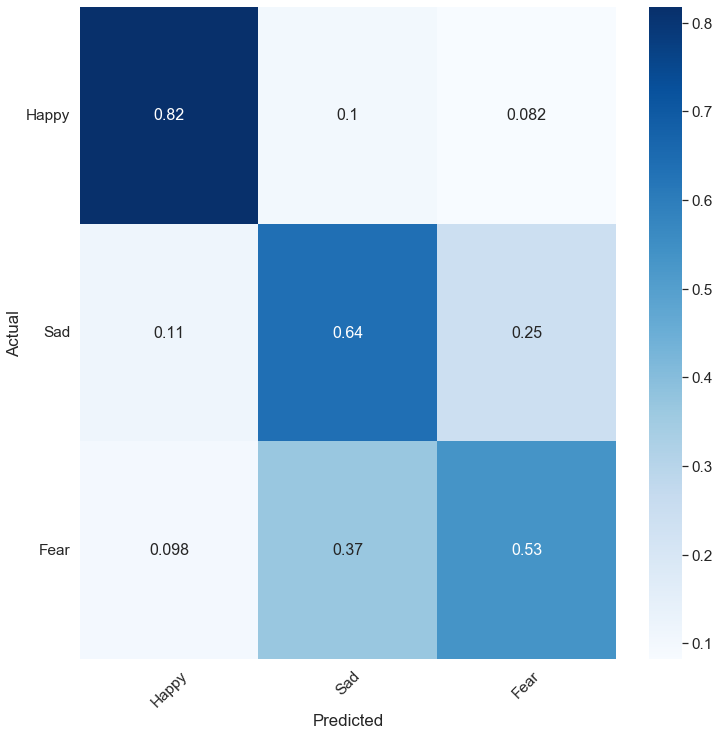

In [34]:
show_results(id2cls, test_Y.tolist(), prediction)

## Rough

In [375]:
# model_ft = models.resnet101(pretrained = True)
# model_ft = models.resnext101_32x8d(pretrained=True)
# model_ft = models.wide_resnet101_2(pretrained = True)
model_ft = models.vgg19(pretrained = True)
# model_ft.Conv2d_1a_3x3.conv = nn.Conv2d(1, 64, kernel_size = (3, 3), stride=(2,2), bias=False)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 3)
# model_ft.parameters.0

In [325]:
# for param in model.resnet.parameters():
#     print(param.requires_grad)